In [176]:
import os.path
from datetime import datetime as dt

import keras.utils.vis_utils
import keras_tuner as kt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
from IPython.display import display, clear_output
from dateutil.relativedelta import relativedelta
from keras import Sequential, layers, losses, metrics, activations
from keras import callbacks
from keras.api.keras import optimizers

import file_helper

In [42]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
DATE_FORMAT = '%d.%m.%Y'

In [44]:
def convert_string_to_date(string_date: str) -> dt:
    return dt.strptime(string_date, DATE_FORMAT)

def normalize_columns_in_dataframe(data: pd.DataFrame, columns: list[str] = None) -> None:
    data_columns = data[columns]
    min_values = data_columns.min()
    max_values = data_columns.max()
    data[columns] = (data_columns - min_values) / (max_values - min_values)

In [45]:
geochem_data = pd.read_excel(file_helper.get_geo_chem_file_path(), 'dubki_h_tau')

In [46]:
events_catalog_data = pd.read_csv(file_helper.get_events_catalog_file_path(), sep=';').iloc[10000:]
events_catalog_data['Date'] = pd.to_datetime(events_catalog_data['Date'], format=DATE_FORMAT)

In [373]:
DATE_TARGET_OFFSET = relativedelta(months=3)
DATE_TARGET_DURATION = relativedelta(months=1)
STARTING_EVENT_CLASS = 13

In [374]:
def split_data(date_target_offset: relativedelta, date_target_duration: relativedelta, starting_event_class) -> (pd.DataFrame, pd.DataFrame):
    preprocessed_data = pd.DataFrame(geochem_data).copy()

    normalize_columns_in_dataframe(preprocessed_data, ['events', 'ascend', 'maximum', 'descend', 'minimum'])

    breakpoint_date = convert_string_to_date('31.12.2021') - date_target_offset - date_target_duration
    reserved_data = preprocessed_data[breakpoint_date < preprocessed_data['to date']].drop(['from date'], axis=1)
    preprocessed_data = preprocessed_data[preprocessed_data['to date'] <= breakpoint_date]
    preprocessed_data['target'] = preprocessed_data['to date'].map(lambda date: 1 if len(events_catalog_data[
        ((date + date_target_offset) <= events_catalog_data['Date'])
        & (events_catalog_data['Date'] <= (date + date_target_offset + date_target_duration))
        & (starting_event_class <= events_catalog_data['Class'])
    ]) > 0 else 0)
    preprocessed_data = preprocessed_data.drop(['from date', 'to date'], axis=1)

    return preprocessed_data, reserved_data

In [375]:
preprocessed_data, reserved_data = split_data(DATE_TARGET_OFFSET, DATE_TARGET_DURATION, STARTING_EVENT_CLASS)

In [376]:
# display(
#     preprocessed_data.tail(),
#     reserved_data.head()
# )
# geochem_data.head()

In [377]:
RANDOM_STATE = 42
TRAIN_FRAC = .8

In [378]:
def generate_train_test(data: pd.DataFrame):
    x = data.drop(['target'], axis=1)
    y = data['target']

    x_train, y_train = x.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE), y.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE)
    x_test, y_test = x.drop(x_train.index), y.drop(y_train.index)

    return (x_train, y_train), (x_test, y_test)

In [379]:
def model_builder(hp: kt.HyperParameters):
    # hp_date_target_offset_months = hp.Int('offset', 1, 12)
    # hp_date_target_duration_months = hp.Int('duration', 1, 12)

    hp_activation = hp.Choice('activation', values=['linear', 'relu', 'tanh', 'sigmoid'])
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    hp_activation_1 = hp.Choice('activation_1', values=['linear', 'relu', 'tanh', 'sigmoid'])
    hp_units_1 = hp.Int('units_1', min_value=8, max_value=128, step=8)
    hp_activation_2 = hp.Choice('activation_2', values=['linear', 'relu', 'tanh', 'sigmoid'])
    hp_units_2 = hp.Int('units_2', min_value=8, max_value=128, step=8)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = Sequential([
        layers.InputLayer((5,), name='input'),
        layers.Dense(units=hp_units, activation=hp_activation, name='dense_0'),
        layers.Dense(units=hp_units_1, activation=hp_activation_1, name='dense_1'),
        layers.Dense(units=hp_units_2, activation=hp_activation_2, name='dense_2'),
        layers.Dense(1, name='output')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
        loss=losses.BinaryCrossentropy(from_logits=True),
        metrics=[metrics.BinaryAccuracy(name='accuracy')]
    )

    return model

In [380]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=200,
    factor=3,
    directory=os.path.join(file_helper.get_root_path(), f'data/hypermodel/date_o_d/{DATE_TARGET_OFFSET.months}/{DATE_TARGET_DURATION.months}'),
    project_name='geo_analysis'
)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\saaru\PycharmProjects\geo\data/hypermodel/date_o_d/3/1\geo_analysis\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\saaru\PycharmProjects\geo\data/hypermodel/date_o_d/3/1\geo_analysis\tuner0.json


In [381]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [382]:
(x_train, y_train), (x_test, y_test) = generate_train_test(preprocessed_data)

In [383]:
tuner.search(x_train, y_train, epochs=100, validation_split=.2, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Oracle triggered exit


In [384]:
def search_best_model(seed: int=None):
    START_MONTH = 1
    END_MONTH = 12

    last_score = -1.
    best_score = -1.
    best_offset, best_duration = (-1, -1)

    for offset in range(START_MONTH, END_MONTH + 1):
        for duration in range(START_MONTH, END_MONTH + 1):
            clear_output(wait=True)
            print(f'{"Offset":10}: {offset}\n{"Duration":10}: {duration}')
            print(f'Best offset: {best_offset}\nBest duration: {best_duration}')
            print(f'Last score: {last_score}')
            print(f'Best score: {best_score}')

            date_target_offset = relativedelta(months=offset)
            date_target_duration = relativedelta(months=duration)

            stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=10)

            preprocessed_data, reserved_data = split_data(date_target_offset, date_target_duration, STARTING_EVENT_CLASS)
            (x_train, y_train), _ = generate_train_test(preprocessed_data)

            # split_index = int(x_train.shape[0] * .8)
            #
            # x_val, y_val = x_train[split_index:], y_train[split_index:]
            # x_train, y_train = x_train[:split_index], y_train[:split_index]
            #
            # train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
            # val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32).cache().prefetch(tf.data.AUTOTUNE)

            tuner = kt.Hyperband(
                model_builder,
                objective='val_accuracy',
                max_epochs=200,
                factor=3,
                seed=seed,
                directory=os.path.join(file_helper.get_root_path(), f'data/hypermodel/date_o_d/{offset}/{duration}'),
                project_name='geo_analysis'
            )

            tuner.search(
                # train_dataset,
                x_train, y_train,
                epochs=100,
                validation_split=.2,
                # validation_data=val_dataset,
                callbacks=[stop_early]
            )
            score = tuner.oracle.get_best_trials(num_trials=1)[0].score

            if best_score < score:
                best_score = score
                best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
                best_preprocessed = preprocessed_data
                best_reserved = reserved_data
                best_tuner = tuner
                best_offset, best_duration = (offset, duration)
            last_score = score

    model = best_tuner.hypermodel.build(best_hps)

    print(f'{"Best score":10}:{best_score}\n{"Offset":10}:{best_offset}\n{"Duration":10}:{best_duration}')

    return model, best_preprocessed, best_reserved, best_hps

In [385]:
# model, preprocessed_data, reserved_data, best_hps = search_best_model(seed=42)

In [386]:
print(*[f'{k:20}: {v}' for k, v in best_hps.values.items()], sep='\n')

activation          : tanh
units               : 120
activation_1        : relu
units_1             : 72
activation_2        : tanh
units_2             : 64
learning_rate       : 0.001
tuner/epochs        : 200
tuner/initial_epoch : 67
tuner/bracket       : 2
tuner/round         : 2
tuner/trial_id      : 0228


In [763]:
# model = Sequential([
#     layers.InputLayer(input_shape=(5,), name='input'),
#     layers.Dense(120, activation=activations.tanh, name='dense_0'),
#     layers.Dense(72, activation=activations.relu, name='dense_1'),
#     layers.Dense(64, activation=activations.tanh, name='dense_2'),
#     layers.Dense(1, name='output')
# ])
# model.compile(
#     optimizer=optimizers.Adam(name='adam', learning_rate=.001),
#     loss=losses.BinaryCrossentropy(name='binary_crossentropy', from_logits=True),
#     metrics=[metrics.BinaryAccuracy(name='accuracy')]
# )

model = tuner.hypermodel.build(best_hps)

In [764]:
total_count = len(preprocessed_data)
neg_count = len(preprocessed_data[preprocessed_data['target'] == 0]['target'])
pos_count = len(preprocessed_data[preprocessed_data['target'] == 1]['target'])

weight_0 = (1 / neg_count) * (total_count / 2.0)
weight_1 = (1 / pos_count) * (total_count / 2.0)

print(weight_0, weight_1)
print(f'Negatives: {neg_count/total_count*100}%')
print(f'Positives: {pos_count/total_count*100}%')

0.5203116304952699 12.808219178082192
Negatives: 96.09625668449198%
Positives: 3.9037433155080214%


In [765]:
# (x_train, y_train), (x_test, y_test) = generate_train_test(preprocessed_data)

# For performance, change later model input
split_index = int(x_train.shape[0] * .8)

x_trains, y_trains = x_train[:split_index], y_train[:split_index]
x_val, y_val = x_train[split_index:], y_train[split_index:]

BATCH_SIZE = 128
BUFFER_SIZE = 4096

train_dataset = tf.data.Dataset.from_tensor_slices((x_trains, y_trains)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

history = model.fit(
    # x_train, y_train,
    train_dataset,
    epochs=256,
    # epochs=best_hps.get('tuner/epochs'),
    # validation_split=.2,
    validation_data=val_dataset,
    # verbose=0,
    class_weight={0: weight_0, 1: weight_1},
    # callbacks=[stop_early],
)
# len(history.history['val_loss'])

Epoch 1/256
29/29 [==============================] - 1s 21ms/step - loss: 0.6948 - accuracy: 0.9607 - val_loss: 0.6215 - val_accuracy: 0.9588
Epoch 2/256
29/29 [==============================] - 0s 15ms/step - loss: 0.6780 - accuracy: 0.9607 - val_loss: 0.6169 - val_accuracy: 0.9588
Epoch 3/256
29/29 [==============================] - 0s 14ms/step - loss: 0.6390 - accuracy: 0.9579 - val_loss: 0.5437 - val_accuracy: 0.9588
Epoch 4/256
29/29 [==============================] - 0s 14ms/step - loss: 0.5872 - accuracy: 0.9201 - val_loss: 0.5079 - val_accuracy: 0.9321
Epoch 5/256
29/29 [==============================] - 0s 14ms/step - loss: 0.5227 - accuracy: 0.8616 - val_loss: 0.4086 - val_accuracy: 0.9165
Epoch 6/256
29/29 [==============================] - 0s 15ms/step - loss: 0.4750 - accuracy: 0.8145 - val_loss: 0.3505 - val_accuracy: 0.9076
Epoch 7/256
29/29 [==============================] - 0s 14ms/step - loss: 0.4428 - accuracy: 0.8139 - val_loss: 0.3304 - val_accuracy: 0.8987
Epoch 

In [766]:
model.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 120)               720       
                                                                 
 dense_1 (Dense)             (None, 72)                8712      
                                                                 
 dense_2 (Dense)             (None, 64)                4672      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 14,169
Trainable params: 14,169
Non-trainable params: 0
_________________________________________________________________


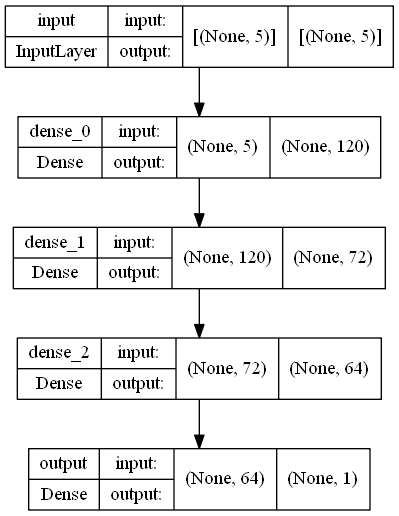

In [767]:
keras.utils.vis_utils.plot_model(model, show_shapes=True)

In [768]:
model.evaluate(test_dataset)

9/9 [==============================] - 0s 10ms/step - loss: 0.0855 - accuracy: 0.9661


[0.08552596718072891, 0.9661319255828857]

In [791]:
y_pred = tf.round(tf.nn.sigmoid(model.predict(x_test)))

tp = keras.metrics.TruePositives(name='tp')
tp.update_state(y_test, y_pred)

fp = keras.metrics.FalsePositives(name='fp')
fp.update_state(y_test, y_pred)

tn = keras.metrics.TrueNegatives(name='tn')
tn.update_state(y_test, y_pred)

fn = keras.metrics.FalseNegatives(name='fn')
fn.update_state(y_test, y_pred)

print(f'{"=" * 33}')
print(f'|| {" " * 9} | {"Actual":15} ||')
print(f'|| {"Predicted":9} | {"-" * 15} ||')
print(f'|| {" " * 9} | {"True":6} | {"False":6} ||')
print(f'|| {"-" * 9} + {"-" * 6} + {"-" * 6} ||')
print(f'|| {"Pos":9} | {tp.result():6} | {fp.result():6} ||')
print(f'|| {"-" * 9} + {"-" * 6} + {"-" * 6} ||')
print(f'|| {"Neg":9} | {fn.result():6} | {tn.result():6} ||')
print(f'{"=" * 33}')

||           | Actual          ||
|| Predicted | --------------- ||
||           | True   | False  ||
|| --------- + ------ + ------ ||
|| Pos       |   41.0 |   37.0 ||
|| --------- + ------ + ------ ||
|| Neg       |    0.0 | 1044.0 ||


In [770]:
condition = (convert_string_to_date('1.1.2021') <= reserved_data['to date'])

X_pred = reserved_data[condition].drop(['to date'], axis=1)

# X_pred = processed_data[condition]

result_pred = model.predict(X_pred)
result_proba = tf.nn.sigmoid(result_pred).numpy()

In [771]:
figure_x = reserved_data[condition]['to date']
figure_x_text = figure_x.map(lambda e: f'[{(e + DATE_TARGET_OFFSET).strftime("%d.%m.%Y")}..{(e + DATE_TARGET_OFFSET + DATE_TARGET_DURATION).strftime("%d.%m.%Y")}]')
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=figure_x,
    y=1-result_proba[:,0],
    mode='lines',
    stackgroup='one',
    line=dict(width=.25),
    groupnorm='percent',
    name='No event',
    text=figure_x_text
))
fig.add_trace(go.Scatter(
    x=figure_x,
    y=result_proba[:,0],
    mode='lines',
    stackgroup='one',
    line=dict(width=.25),
    name='Event predicted',
    text=figure_x_text
))
fig.update_layout(
    title='Probability of event',
    # width=500, height=500
)
fig.show()

In [772]:
result = pd.DataFrame(reserved_data[condition])

In [773]:
result['predicted'] = result_pred
result[(result['predicted'] > 0)]['to date'].map(
    lambda date:
    f'K >= {STARTING_EVENT_CLASS}; Dates [{(date + DATE_TARGET_OFFSET).strftime("%d.%m.%Y")}..{(date + DATE_TARGET_OFFSET + DATE_TARGET_DURATION).strftime("%d.%m.%Y")}]'
)

Series([], Name: to date, dtype: object)